In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [2]:
# churn.csv
churn_df = pd.read_csv("./data/churn.csv")
churn_df["lastParticipationDate"] = pd.to_datetime(churn_df["lastParticipationDate"]).dt.normalize()

# comments_clean_anonymized.csv
cca_df = pd.read_csv("./data/comments_clean_anonymized.csv")
cca_df['commentDate'] = pd.to_datetime(cca_df['commentDate']).dt.normalize()
cca_df.head()

# votes
votes_df = pd.read_csv("./data/votes.csv")
votes_df["voteDate"] = pd.to_datetime(votes_df["voteDate"]).dt.normalize()
votes_df.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/python_dateutil-2.8.1-py3.8.egg/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname CET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/python_dateutil-2.8.1-py3.8.egg/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname CEST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,employee,companyAlias,voteDate,vote
0,31,56aec740f1ef260003e307d6,2016-02-01,4
1,33,56aec740f1ef260003e307d6,2016-02-01,4
2,79,56aec740f1ef260003e307d6,2016-02-01,4
3,94,56aec740f1ef260003e307d6,2016-02-01,4
4,16,56aec740f1ef260003e307d6,2016-02-01,2


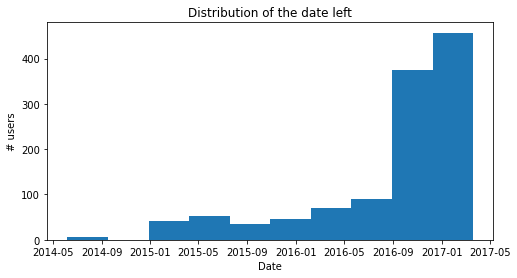

In [3]:
# show the date distribution of employees who left the company
churned_emp = churn_df[churn_df["stillExists"] == False]
plt.figure(figsize=(8, 4))
plt.hist(churned_emp['lastParticipationDate'])
plt.title("Distribution of the date left")
plt.xlabel("Date")
plt.ylabel("# users")
plt.show()

In [4]:
# Pick an arbitrary date
import datetime
date = datetime.datetime(2016, 11, 1)

In [5]:
# Find employees that have commented before a date
cca_sliced = cca_df[cca_df['commentDate'] <= date][["employee", "companyAlias"]]
cca_sliced = cca_sliced.drop_duplicates()
cca_sliced.describe()

,employee
count,2240.000000
mean,127.437946
std,170.321682
min,-217.000000
25%,25.000000
50%,92.000000
75%,191.250000
max,999.000000


In [6]:
# Find employees that have voted before a date
# Calculate the range of the date. 
votes_group = votes_df.groupby(["employee", "companyAlias"]).agg({"voteDate": "min"}).reset_index()
votes_sliced = votes_group[votes_group["voteDate"] <= date][["employee", "companyAlias"]]
votes_sliced

,employee,companyAlias
0,1,5474b9cde4b0bf7614b2c66f
1,1,54d43612e4b0f6a40755d93e
2,1,54e52607e4b01191dc064966
3,1,5641f96713664c000332c8cd
4,1,56558cfd07a5de00030908fb
...,...,...
4371,989,54e52607e4b01191dc064966
4372,991,54e52607e4b01191dc064966
4373,995,54e52607e4b01191dc064966
4374,996,54e52607e4b01191dc064966


In [7]:
# Get all active employees prior to the observation date
active_user_prior_to_date = pd.merge(votes_sliced, 
                                     cca_sliced, 
                                     on=["employee", "companyAlias"], 
                                     how="outer")
active_user_prior_to_date

,employee,companyAlias
0,1,5474b9cde4b0bf7614b2c66f
1,1,54d43612e4b0f6a40755d93e
2,1,54e52607e4b01191dc064966
3,1,5641f96713664c000332c8cd
4,1,56558cfd07a5de00030908fb
...,...,...
3423,-7,57ac8b23be7fe30003e656d0
3424,-2,5742d699f839a10003a407d2
3425,-4,5742d699f839a10003a407d2
3426,-5,5742d699f839a10003a407d2


In [8]:
# assuming lastParticipationDate is close to the date employees left the company, get
# all existing employees after the end of the "observation date"
churned_emp_before_date = churn_df[(churn_df['lastParticipationDate'] <= date) 
                                   & (churn_df['stillExists'] == False)][["employee", "companyAlias"]]
churned_emp_before_date.describe()

,employee
count,593.00000
mean,166.10118
std,306.87744
min,-218.00000
25%,-90.00000
50%,96.00000
75%,316.00000
max,989.00000


In [9]:
# Right join two datasets to get all active employees as of the observation date
active_emp_on_date = pd.merge(churned_emp_before_date, active_user_prior_to_date, 
                      on=["employee", "companyAlias"], 
                      how="right", indicator=True)
active_emp_on_date = active_emp_on_date[active_emp_on_date["_merge"] 
                                        == "right_only"].dropna()
active_emp_on_date.drop(labels=["_merge"], axis=1, inplace=True)
active_emp_on_date

,employee,companyAlias
0,1,5474b9cde4b0bf7614b2c66f
3,1,5641f96713664c000332c8cd
4,1,56558cfd07a5de00030908fb
5,1,567011c035dce00003a07fa4
6,1,56ae7b02f1ef260003e3072c
...,...,...
3441,-5,57ac8b23be7fe30003e656d0
3442,-2,57ac8b23be7fe30003e656d0
3444,-2,5742d699f839a10003a407d2
3446,-5,5742d699f839a10003a407d2


In [10]:
emp_list = pd.merge(churn_df, active_emp_on_date, on=["employee", "companyAlias"], how="right")
emp_list.dropna(inplace=True)
emp_list

,employee,companyAlias,numVotes,lastParticipationDate,stillExists
0,1,5474b9cde4b0bf7614b2c66f,2.0,2014-11-26,True
1,1,5641f96713664c000332c8cd,257.0,2017-03-19,True
2,1,56558cfd07a5de00030908fb,2.0,2015-11-29,True
3,1,567011c035dce00003a07fa4,1.0,2016-06-08,True
4,1,56ae7b02f1ef260003e3072c,5.0,2016-10-04,True
...,...,...,...,...,...
2907,-2,57dd2d6a4018d9000339ca43,0.0,2016-12-31,False
2908,-4,57dd2d6a4018d9000339ca43,0.0,2016-12-31,False
2915,-4,57ac8b23be7fe30003e656d0,0.0,2016-12-07,False
2916,-5,57ac8b23be7fe30003e656d0,0.0,2016-11-23,False


In [11]:
emp_list.describe()

,employee,numVotes
count,2894.000000,2894.000000
mean,153.127160,65.201106
std,169.063132,81.796014
min,-85.000000,0.000000
25%,42.000000,8.000000
50%,109.000000,33.000000
75%,205.000000,93.000000
max,999.000000,740.000000


In [12]:
emp_list[emp_list['stillExists'] == False].count()

employee                 304
companyAlias             304
numVotes                 304
lastParticipationDate    304
stillExists              304
dtype: int64

In [13]:
emp_list[emp_list['stillExists'] == True].count()

employee                 2590
companyAlias             2590
numVotes                 2590
lastParticipationDate    2590
stillExists              2590
dtype: int64

In [14]:
# Save the list for future use
emp_list.to_csv("./data/emp_list.csv")